# Churn analysis and visualization by SQL (and Seaborns)

## Preparation
I have to change the plain text of the .csv file to data, and setting up the database for running this notebook.

In [1]:
import pandas as pd
import duckdb
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#Configuration the SQLAlchemy
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

#import ipython-sql to Jupyter to create SQL cell, and connect with the duckdb
%load_ext sql
%sql duckdb:///:memory:
# DuckDB would read the files from the memories, like when I save a dataframe on a variable, it would accept to directly query from it.

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [5]:
#Using Pandas, import the dataframes
legislators = pd.read_csv('legislators.csv')
legislators_terms = pd.read_csv('legislators_terms.csv')

#legislators terms data-type format
legislators_terms["term_start"] = legislators_terms["term_start"].astype('datetime64[ns]')
legislators_terms["term_end"] = legislators_terms["term_end"].astype('datetime64[ns]')
legislators_terms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44063 entries, 0 to 44062
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id_bioguide   44063 non-null  object        
 1   term_number   44063 non-null  int64         
 2   term_id       44063 non-null  object        
 3   term_type     44063 non-null  object        
 4   term_start    44063 non-null  datetime64[ns]
 5   term_end      44063 non-null  datetime64[ns]
 6   state         44063 non-null  object        
 7   district      40190 non-null  float64       
 8   class         3873 non-null   float64       
 9   party         43611 non-null  object        
 10  how           201 non-null    object        
 11  url           4386 non-null   object        
 12  address       2499 non-null   object        
 13  phone         2494 non-null   object        
 14  fax           1812 non-null   object        
 15  contact_form  1430 non-null   object

This would be the magic part, I will fucking use SQL in the Python cell (by using the SQLAlchemy engine, with DuckDB). This kind of stack is optimal for OLAP, since they can run the database right on the memory of the machine and use T-SQL to transform the view of the data as they want right in the pipeline.

In [60]:
%%sql
SELECT 
    id_bioguide,
    min(term_start) as first_term
FROM legislators_terms
GROUP BY 1;

,id_bioguide,first_term
0,F000062,1992-11-10
1,T000464,2007-01-04
2,A000360,2003-01-07
3,G000359,1995-01-04
4,R000307,1981-01-05
...,...,...
12513,R000409,1989-01-03
12514,B000426,1951-01-03
12515,F000445,2001-06-26
12516,J000267,1958-04-19


## The overall query of cohort for this case

In [7]:
%%sql cohort_table <<
SELECT
    period,
    first_value(cohort_retained) over (order by period) as cohort_size,
    cohort_retained,
    cohort_retained::DOUBLE / 
        (first_value(cohort_retained) 
                    over (order by period))::DOUBLE AS pct_retention
FROM 
(
    SELECT 
        date_part('year', AGE(b.term_start, a.first_term)) as period,
        COUNT(DISTINCT a.id_bioguide) as cohort_retained
    FROM 
    (
        SELECT 
            id_bioguide,
            min(term_start) as first_term
        FROM legislators_terms
        GROUP BY 1
    ) a
    JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
    GROUP BY 1   
) aa
;

Returning data to local variable cohort_table


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


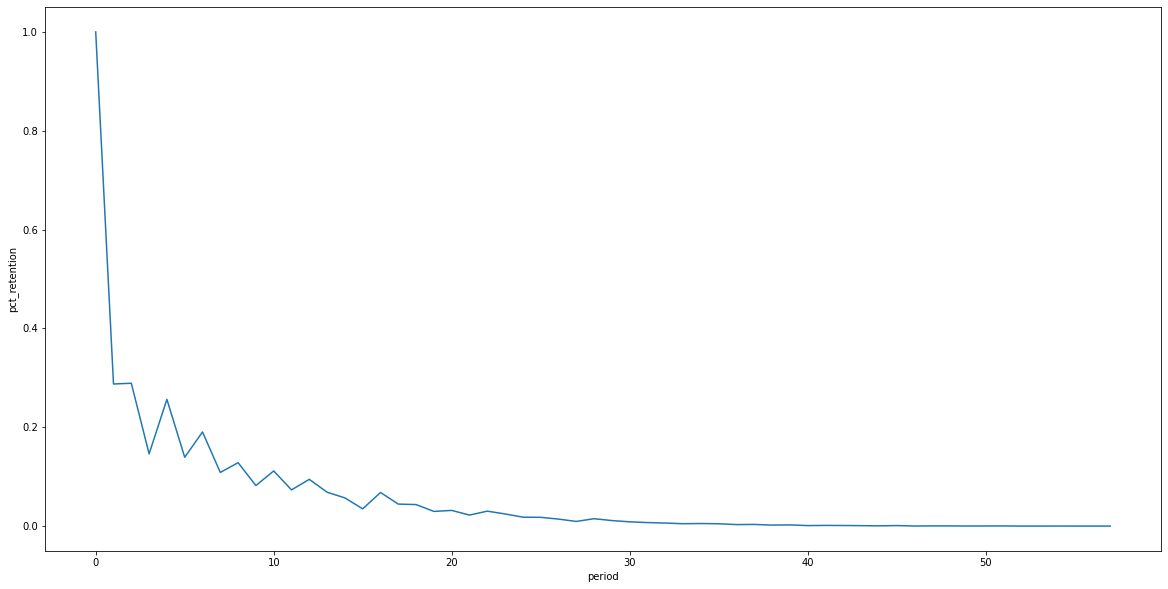

In [13]:
#plot the retention table
plt.figure(figsize=(20,10))
sns.lineplot(cohort_table.period, cohort_table.pct_retention)
plt.show()

### Breakdown the queries over there

First of all, the query would detect the starting term of each legislator from the legislator terms table, then return the id of each one to group by in the following step. Of course, they have to be grouped by the id so we have the `GROUP BY 1`.

In [6]:
%%sql
SELECT 
    id_bioguide,
    min(term_start) as first_term
FROM legislators_terms
GROUP BY 1;

,id_bioguide,first_term
0,F000062,1992-11-10
1,T000464,2007-01-04
2,A000360,2003-01-07
3,G000359,1995-01-04
4,R000307,1981-01-05
...,...,...
12513,R000409,1989-01-03
12514,B000426,1951-01-03
12515,F000445,2001-06-26
12516,J000267,1958-04-19


Next, the table above would be joined with legislator terms (I mean they will join the main table of legislators_terms, itself), to check period of each person, also the count the distinct id of legislators with that period in terms. The output would have a group by (again) by the period as first column (as period).

In [13]:
%%sql
SELECT 
    date_part('year', AGE(b.term_start, a.first_term)) as period,
    COUNT(DISTINCT a.id_bioguide) as cohort_retained
FROM 
(
    SELECT 
        id_bioguide,
        min(term_start) as first_term
    FROM legislators_terms
    GROUP BY 1
) a
JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
GROUP BY 1
LIMIT 5;

,period,cohort_retained
0,26,178
1,11,918
2,20,398
3,34,66
4,21,280


In the final layer, the code would simply select the max period from the column of the cohort retained (as the initial population = 100%), then use the cohort retained divided by that value to create the percentage of cohort in each period.

In [86]:
%%sql
SELECT
    period,
    first_value(cohort_retained) over (order by period) as cohort_size,
    cohort_retained,
    cohort_retained::DOUBLE / (first_value(cohort_retained) 
                                over (order by period))::DOUBLE as pct_cohort
FROM 
(
    SELECT 
        date_part('year', AGE(b.term_start, a.first_term)) as period,
        COUNT(DISTINCT a.id_bioguide) as cohort_retained
    FROM 
    (
        SELECT 
            id_bioguide,
            min(term_start) as first_term
        FROM legislators_terms
        GROUP BY 1
    ) a
    JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
    GROUP BY 1   
) aa
LIMIT 5;

,period,cohort_size,cohort_retained,pct_cohort
0,0,12518,12518,1.000000
1,1,12518,3600,0.287586
2,2,12518,3619,0.289104
3,3,12518,1831,0.146269
4,4,12518,3210,0.256431


See, I still hate the fact that somehow the dividing calculation is auto-rounded to 0 like this so I have to use pandas to divide these columns.

And all of these database would be limited by 5 to better view of the notebook.

## More queries, more fun

I will try to do some other queries from the original one, since the cohort might be cooler than I thought. 

Aight don't touch the time - date period, this might be another day for this due to the techstack right now is pretty weird to have another Date_DIM table (yeah I know).

Let's see what can I do with grouping them by some kind of elements/columns in the database.

### Query the cohort by states

In [91]:
%%sql cohort_by_state <<
SELECT
    period,
    state,
    first_value(cohort_retained) over (partition by state 
                                        order by period) as cohort_size,
    cohort_retained,
    cohort_retained::DOUBLE / (first_value(cohort_retained) 
                                over (partition by state order by period))::DOUBLE
                                 as pct_cohort
FROM 
(
    SELECT 
        date_part('year', AGE(b.term_start, a.first_term)) as period,
        b.state,
        COUNT(DISTINCT a.id_bioguide) as cohort_retained
    FROM 
    (
        SELECT 
            id_bioguide,
            min(term_start) as first_term
        FROM legislators_terms
        GROUP BY 1
    ) a
    JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
    GROUP BY 1, 2   
) aa
;

Returning data to local variable cohort_by_state


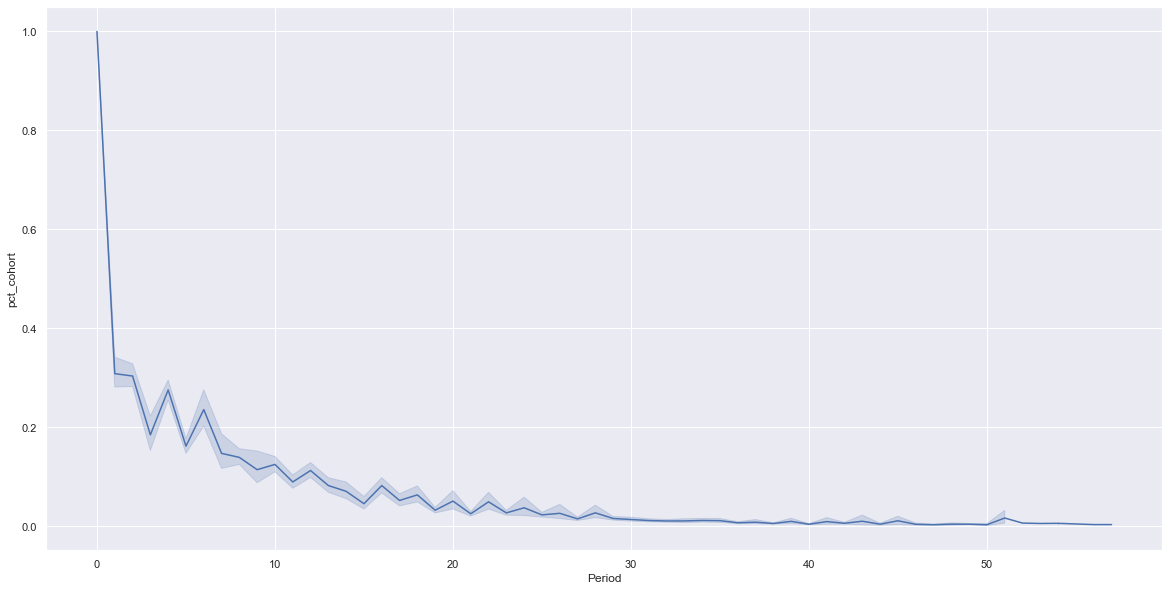

In [92]:
#No hue
sns.set(rc={'figure.figsize': (20,10)})
sns.lineplot(data=cohort_by_state, x="period", y="pct_cohort")
plt.xlabel("Period")
plt.show()

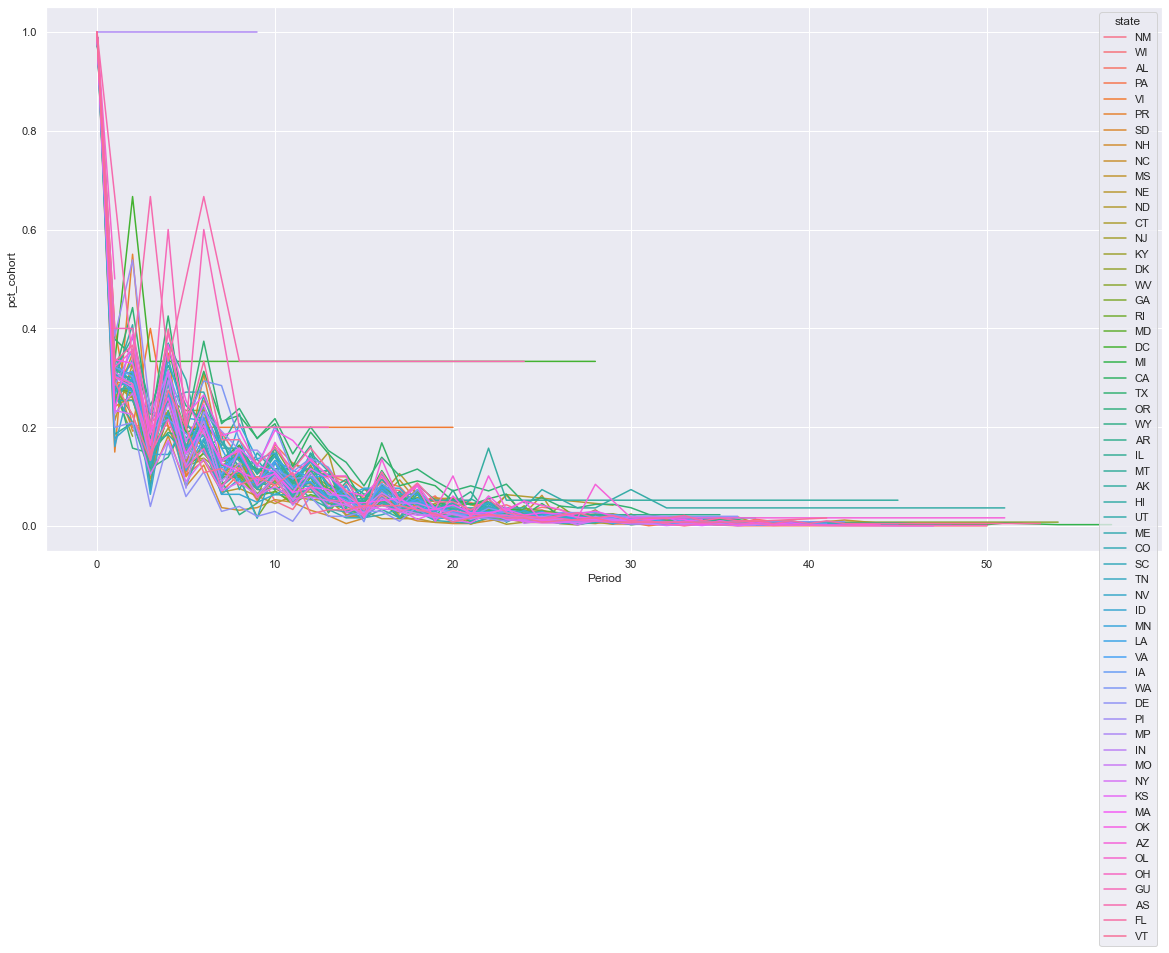

In [93]:
#Hue is state, or the cohort by states
sns.set(rc={'figure.figsize': (20,10)})
sns.lineplot(data=cohort_by_state, x="period", y="pct_cohort", hue="state")
plt.xlabel("Period")
plt.show()

Little bit chaotic but understandable.

### Queries the cohort by genders

In [61]:
%%sql
SELECT 
    date_part('year', AGE(b.term_start, a.first_term)) as period,
    c.gender,
    COUNT(DISTINCT a.id_bioguide) as cohort_retained
FROM 
(
    SELECT 
        id_bioguide,
        min(term_start) as first_term
    FROM legislators_terms
    GROUP BY 1
) a
JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
JOIN legislators c ON c.id_bioguide = b.id_bioguide
GROUP BY 1, 2;  

,period,gender,cohort_retained
0,26,F,8
1,11,M,869
2,20,M,384
3,34,M,63
4,21,M,271
...,...,...,...
89,54,M,2
90,33,F,1
91,57,M,1
92,35,F,1


In [94]:
%%sql cohort_by_gender <<
SELECT
    period,
    gender,
    first_value(cohort_retained) over (partition by gender 
                                        order by period) as cohort_size,
    cohort_retained,
    cohort_retained::DOUBLE / (first_value(cohort_retained) 
                                over (partition by gender order by period))::DOUBLE
                                as pct_cohort
FROM 
(
    SELECT 
        date_part('year', AGE(b.term_start, a.first_term)) as period,
        c.gender,
        COUNT(DISTINCT a.id_bioguide) as cohort_retained
    FROM 
    (
        SELECT 
            id_bioguide,
            min(term_start) as first_term
        FROM legislators_terms
        GROUP BY 1
    ) a
    JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
    JOIN legislators c ON c.id_bioguide = b.id_bioguide
    GROUP BY 1, 2   
) aa
;

Returning data to local variable cohort_by_gender


This part is where i have to check the survivor's bias since yeah, I have just took the overal cohort size to calculate the cohort percentage -> the retention cohort would be higher since the number of men is larger than women.

It can be fixed by use the partition by gender on the select part of top layer.

In [95]:
cohort_by_gender.head()

,period,gender,cohort_size,cohort_retained,pct_cohort
0,0,F,366,366,1.000000
1,1,F,366,122,0.333333
2,2,F,366,112,0.306011
3,3,F,366,61,0.166667
4,4,F,366,136,0.371585


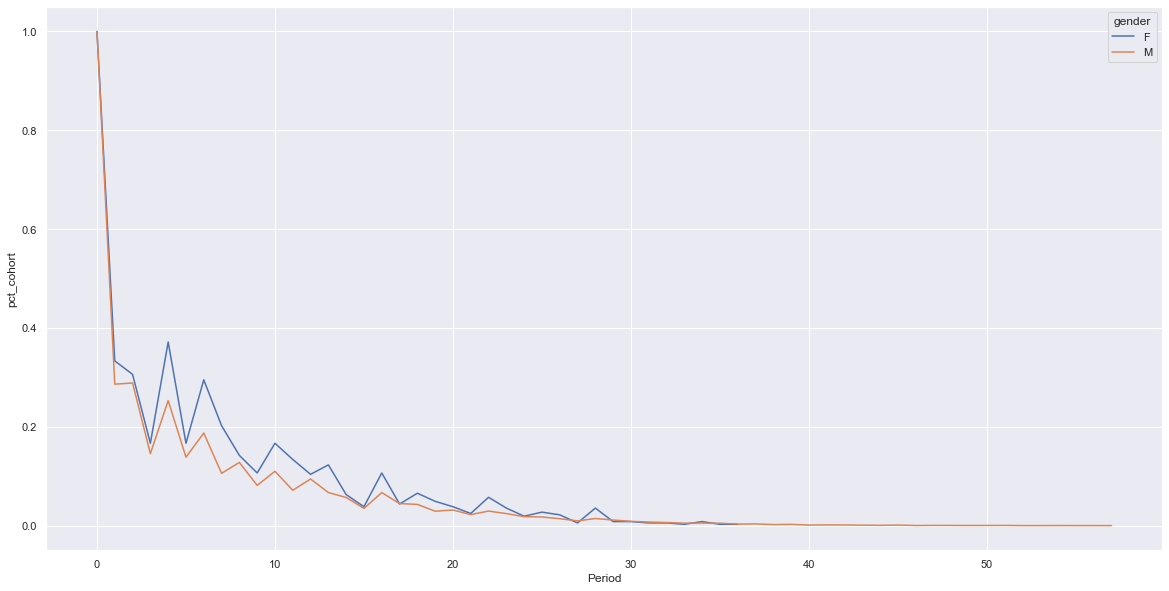

In [96]:
sns.lineplot(data=cohort_by_gender, x="period", y="pct_cohort", hue="gender")
plt.xlabel("Period")
plt.show()

### Date-time period one: for real

First, create a date dimension (copy from [Github](https://gist.github.com/adityawarmanfw/0612333605d351f2f1fe5c87e1af20d2) because we always need built in date-dim table)

In [38]:
%%sql date_dim <<
WITH generate_date AS (
    SELECT CAST(RANGE AS DATE) AS date_key 
     FROM RANGE(DATE '1990-01-01', DATE '2010-12-31', INTERVAL 1 DAY)
    )
SELECT date_key AS date_key,
        DAYOFYEAR(date_key) AS day_of_year, 
        YEARWEEK(date_key) AS week_key,
        WEEKOFYEAR(date_key) AS week_of_year,
        DAYOFWEEK(date_key) AS day_of_week,
        ISODOW(date_key) AS iso_day_of_week,
        DAYNAME(date_key) AS day_name,
        DATE_TRUNC('week', date_key) AS first_day_of_week,
        DATE_TRUNC('week', date_key) + 6 AS last_day_of_week,
        YEAR(date_key) || RIGHT('0' || MONTH(date_key), 2) AS month_key,
        MONTH(date_key) AS month_of_year,
        DAYOFMONTH(date_key) AS day_of_month,
        LEFT(MONTHNAME(date_key), 3) AS month_name_short,
        MONTHNAME(date_key) AS month_name,
        DATE_TRUNC('month', date_key) AS first_day_of_month,
        LAST_DAY(date_key) AS last_day_of_month,
        CAST(YEAR(date_key) || QUARTER(date_key) AS INT) AS quarter_key,
        QUARTER(date_key) AS quarter_of_year,
        CAST(date_key - DATE_TRUNC('Quarter', date_key) + 1 AS INT) AS day_of_quarter,
        ('Q' || QUARTER(date_key)) AS quarter_desc_short,
        ('Quarter ' || QUARTER(date_key)) AS quarter_desc,
        DATE_TRUNC('quarter', date_key) AS first_day_of_quarter,
        LAST_DAY(DATE_TRUNC('quarter', date_key) + INTERVAL 2 MONTH) as last_day_of_quarter,
        CAST(YEAR(date_key) AS INT) AS year_key,
        DATE_TRUNC('Year', date_key) AS first_day_of_year,
        DATE_TRUNC('Year', date_key) - 1 + INTERVAL 1 YEAR AS last_day_of_year,
        ROW_NUMBER() OVER (PARTITION BY YEAR(date_key), MONTH(date_key), DAYOFWEEK(date_key) ORDER BY date_key) AS ordinal_weekday_of_month
    FROM generate_date

Returning data to local variable date_dim


Next, query